# Comparing sea ice concentration products to ice charts


Production date: 14-04-2025

Produced by: Timothy Williams, Nansen Environment and Remote Sensing Center

## 🌍 Use case: Assessing the uncertainty of sea ice concentration products

## ❓ Quality assessment question
**How does the interim sea ice concentration product compare to manual ice charts?**
To assess the uncertainty in the sea ice concontration products, we compare the sea ice concentration derived from passive microwave SSMIS (Special Sensor Microwave Imager/Sounder) sensors, to manual ice charts from the United States National Ice Center (NIC). These ice charts only date back to 2016, which is why we only compare them to the SSMIS products, and not the AMSR (Advanced Microwave Scanning Radiometer) product.

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
Sea ice concentration produced by the EUMETSAT (European Organisation for the Exploitation of Meteorological Satellites) OSI SAF (Ocean and Sea Ice Satellite Application Facility), and derived from SSMIS passive microwave sensors was compared to daily ice charts for both the Arctic and Antarctic. The ice charts are the daily marginal ice zone (MIZ) charts produced by the United States National Ice Center (NIC). The differences were the largest in summer when the concentration from passive microwave sensors has the largest errors due to melt ponds for example. The maximum integrated ice edge error reached $2\times10^6$km$^2$ in the Arctic and $4\times10^6$km$^2$ in the Antarctic. The ice charts are created manually, so we might expect them to be more reliable, but they might also be more conservative (err on the side of too much ice as opposed to too little) due to their use by the shipping industry. Indeed the extent calculated from the ice charts was generally larger than the one from the SSMIS-derived concentration, which would be consistent with the latter possibility. Hence further checking of which is indeed the most reliable should be done.
```

## 📋 Methodology
From the [<span style="color:blue">sea ice concentration dataset</span>](https://cds.climate.copernicus.eu/datasets/satellite-sea-ice-concentration?tab=overview) in the Climate Data Store (CDS), we use the SSMIS CDR (Climate Data Record) product, which covers the years 2016 to 2020, and the SSMIS ICDR (Interim CDR) product, which covers the years 2021 to 2024.

NIC ice charts can be downloaded as shapefiles from [<span style="color:blue">https://usicecenter.gov/</span>](https://usicecenter.gov/) and then rasterized onto the EUMETSAT OSI SAF Arctic or Antarctic grids and saved as daily netCDF files with paths depending on the date according to `nh/%Y/nic_miz_%Y%m%d_nc_pl_a.nc` for the northern hemisphere, and `sh/%Y/nic_miz_%Y%m%d_sc_pl_a.nc` for the southern hemisphere. These paths are relative to a user-defined directory `NIC_ICE_CHARTS_PATH` set below in the `Set parameters` section. The netCDF files can be obtained from the author at the email [<span style="color:blue">timothy.williams@nersc.no</span>](mailto:timothy.williams@nersc.no), otherwise users can do their own rasterizing. There is bash code in the "Code" section which shows how to download shapefiles for a given date.

Having obtained the two datasets on the same grid, we can compare them pixel by pixel. The NIC ice charts have 3 categories depending on estimated sea ice concentration (SIC):
1. $0\% \leq {\rm SIC} \leq 10\%$
2. $10\% < {\rm SIC} \leq 80\%$
3. $80\% <{\rm SIC} \leq 100\%$

We reduced the number of categories from 3 to 2 (open water or ice-covered) by merging categories 2 and 3. The CDS SIC product was also converted to open water or ice-covered categories by using a threshold of SIC > 10%.

We then computed two areas $A_\pm$, where $A_+$ is the total area where the CDS has ice and NIC has no ice, and $A_-$ is the total area where the CDS has no ice and NIC has ice. A "bias" is then defined as $A_+ - A_-$ and an IIEE (integrated ice edge error, or the total area where the classification from the SIC product disagrees with the ice chart classification ([<span style="color:blue">Goessling et al., 2016</span>](https://doi.org/10.1002/2015GL067232)), is defined as $A_+ + A_-$.
Time series of these metrics were then plotted.

To give an idea of the spatial distribution of the differences, for each pixel and month a probability of being ice-covered was calculated for the CDS and the NIC charts. The difference between these monthly probabilities was then calculated and plotted as maps.

The "Analysis and results" section is structured as follows:

**[](section-1)**
  * Instructions on how to download the NIC ice charts (as shapefiles which need to be converted to netcdf).

**[](section-2)**

**[](section-3)**

**[](section-4)**

## 📈 Analysis and results

(section-1)=
### 1. Download NIC shapefiles

#### 1.1 Arctic

Arctic MIZ shapefiles were downloaded from [here](https://usicecenter.gov/Products/ArchiveSearch?table=DailyArctic&product=Arctic%20MIZ%20Chart&linkChange=arc-one). They are available from 11 February 2016 to present. An Arctic shapefile for a given date can be downloaded and extracted with a bash script like:

```
shapefile_date=20160211
product_number=5
zipfile=DownloadArchive?prd=${product_number}$(date -d "$shapefile_date" "+%m%d%Y")
wget https://usicecenter.gov/File/$zipfile
unzip $zipfile
```

`ls $(date -d "$shapefile_date" "+nic_miz%Y%jnc_pl_a")*` gives the following files:
```
nic_miz2016042nc_pl_a.dbf
nic_miz2016042nc_pl_a.prj
nic_miz2016042nc_pl_a.shp
nic_miz2016042nc_pl_a.shp.xml
nic_miz2016042nc_pl_a.shx
```

#### 1.2 Antarctic
Antarctic MIZ shapefiles were downloaded from [here](https://usicecenter.gov/Products/ArchiveSearch?table=DailyAntarctic&product=Antarctic%20MIZ%20Chart&linkChange=ant-one). They are available from 11 February 2016 to present. An Antarctic shapefile for a given date can be downloaded and extracted with a bash script like the one above, but with `product_number=19` instead of 5, and the "nc" in the filename changes to "sc".

(section-2)=
### 2. Parameters, requests and functions definition
- Define parameters and formulate requests for downloading with the EQC toolbox.
- Define functions to be applied to process and reduce the size of the downloaded data.
- Define functions to post-process and visualize the data.

#### 2.1 Import libraries
Import the required libraries, including the EQC toolbox.

In [1]:
import warnings

import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import calendar
from cmocean import cm
import cartopy.crs as ccrs
import cartopy

from c3s_eqc_automatic_quality_control import diagnostics, download, plot


plt.style.use("seaborn-v0_8-notebook")
warnings.filterwarnings("ignore", module="cf_xarray")

#### 2.2 Set parameters
Set the time period to cover with `start_year` and `stop_year`, and set the years in which to plot maps with `map_years`.
Also specify `NIC_ICE_CHARTS_PATH`, the location of the directory with the NIC ice charts (rasterised to NetCDF).

In [2]:
# Time
start_year = 2016
stop_year = 2024

# Path to NIC ice charts
NIC_ICE_CHARTS_PATH = "/data/wp5/williams_timothy/nic_ice_charts"

#### 2.3 Define request
Define the request for downloading using the EQC toolbox.

In [3]:
# allowed time range determined by availability of NIC ice charts
year_min = 2016
year_max = 2024
#  last year of CDR
cdr_max = 2020

map_years = list(range(start_year, stop_year + 1))
for map_year in map_years:
    assert(map_year >= year_min and map_year <= year_max)

collection_id = 'satellite-sea-ice-concentration'
common_request = {
    "origin": "eumetsat_osi_saf",
    "sensor": "ssmis",
    "temporal_aggregation": "daily",
    "variable": "all",
    "version": "v3",
}

# requests for calculating time series of differences between ICDR and NIC
requests_time_series = {
    "CDR": download.update_request_date(
        common_request | {"cdr_type": "cdr"},
        start=f"{max(start_year, year_min)}-01",
        stop=f"{min(stop_year, cdr_max)}-12",
        stringify_dates=True,
    ),
    "ICDR": download.update_request_date(
        common_request | {"cdr_type": "icdr"},
        start=f"{max(start_year, cdr_max + 1)}-01",
        stop=f"{min(stop_year, year_max)}-12",
        stringify_dates=True,
    ),
}

#### 2.4 Functions used in caching of both time series and map data
- `get_nic_data` is used to load the NIC ice charts for the requested hemisphere and time period.
- `get_black_adriatic` loads a mask to exclude the Black and Adriatic Seas from the analysis since they don't typically contain sea ice.

In [4]:
def get_nic_data(time, region):
    files = []
    for t in time:
        f = pd.Timestamp(t.item()).strftime(f"{NIC_ICE_CHARTS_PATH}/{region}/%Y/nic_miz_%Y%m%d_{region[0]}c_pl_a.nc")
        if os.path.exists(f):
            files += [f]
    if len(files) == 0:
        return
    return xr.open_mfdataset(files)


def get_black_adriatic(da):
    # get Black and Adriatic Seas for masking
    return (da["longitude"] > 0.) * (da["longitude"] < 60.) * (da["latitude"] > 0.) * (da["latitude"] <= 48.)

#### 2.5 Functions to cache time series
- `compare_siconc_vs_nic` classifies the satellite sea ice concentration data into the same categories that are in the NIC ice charts, and then calculates the extents and some comparison statistics.
- `compute_siconc_nic_time_series` loads the NIC ice chart data, matches the time data with the satellite sea ice concentration data, and runs the comparison by calling `compare_siconc_vs_nic`.

In [5]:
def compare_siconc_vs_nic(ds, ds_nic):
    ds = ds.convert_calendar("standard", align_on="date")

    # grid cell area of sea ice edge grid
    dims = ("xc", "yc")
    dx = np.diff(ds[dims[0]][:2].values)[0]
    grid_cell_area = (dx ** 2) * 1.0e-6  # 10^6 km2

    # get sea ice concentration and convert to ice/water classification
    lonlat = {v: ds[v][:] for v in ["longitude", "latitude"]}
    sic = ds.cf["sea_ice_area_fraction"].assign_coords(lonlat)
    if sic.attrs.get("units", "") == "(0 - 1)":
        sic *= 100
    sic_threshold = 10
    sic_class = xr.where(sic >= sic_threshold, 2, 1).assign_coords(sic.coords) # 1 = open water, 2 = ice
    sic_class = xr.where(get_black_adriatic(sic), 1, sic_class) # set to open water since NIC never has ice there
    proj_var = sic.grid_mapping
    data_arrays = {}

    # extent from SIC
    data_arrays["extent_cds"] = grid_cell_area * (sic_class - 1).sum(dim=dims)
    data_arrays["extent_cds"].attrs = {
        "standard_name": "sea_ice_extent_from_cds",
        "units": "$10^6$km$^2$",
        "long_name": "Sea ice extent from CDS",
    }
    
    # get NIC classification and compare to the one from SIC
    # - 1 = open water, 2 = miz, 3 = pack
    nic_class = xr.DataArray(ds_nic.cf["sea_ice_classification"], dims=sic.dims, coords=sic.coords)
    nic_ice_mask = (nic_class >= 2)
    
    # extent from NIC
    data_arrays["extent_nic"] = grid_cell_area * nic_ice_mask.sum(dim=dims)
    data_arrays["extent_nic"].attrs = {
        "standard_name": "sea_ice_extent_from_nic",
        "units": "$10^6$km$^2$",
        "long_name": "Sea ice extent from NIC",
    }
    
    # compare the 2 products
    over = (sic_class == 2) * (nic_class == 1)
    under = (sic_class == 1) * nic_ice_mask
    over = grid_cell_area * over.sum(dim=dims)
    under = grid_cell_area * under.sum(dim=dims)

    # add IIEE metric to output
    data_arrays["iiee"] = over + under
    data_arrays["iiee"].attrs = {
        "standard_name": "integrated_ice_edge_error",
        "units": "$10^6$km$^2$",
        "long_name": "Integrated ice edge error",
    }

    # add bias metric to output
    data_arrays["siextent_bias"] = over - under
    data_arrays["siextent_bias"].attrs = {
        "standard_name": "sea_ice_extent_bias",
        "units": "$10^6$km$^2$",
        "long_name": "Sea ice extent bias",
    }
    return xr.Dataset(data_arrays)


def compute_siconc_nic_time_series(ds, region):
    # load NIC data
    ds_nic = get_nic_data(ds["time"], region=region)

    # select the common times
    ds, ds_nic = xr.align(ds, ds_nic, join='inner')
    
    # Compare the sea ice concentration product with the NIC classification
    return compare_siconc_vs_nic(ds, ds_nic)

#### 2.6 Define functions to cache map data
- since both products are daily datasets, `get_probabilities` calculates the probability that a grid cell is ice-covered for the month.
- `postproc_probabilities` does some post-processing to ensure both datasets have the same coordinates and adds a product dimension. It also masks the Black and Adriatic seas as the EUMETSAT OSI-SAF product sometimes shows ice there, while the NIC ice charts never do, which creates a systematic difference that we are not interested in.
- `get_monthly_probabilities` calls `get_NIC_data`, and then `get_probabilities` and `postproc_probabilities` for both the NIC data and the sea ice concentration data. This gives two datasets of monthly probabilities of being ice-covered which are then merged so that the `product` dimension is either `NIC` or `ICDR` (the EUMETSAF OSI-SAF sea ice concentration product).

In [6]:
def get_probabilities(da, sic, **kwargs):
    da = xr.DataArray(
        100 * da.groupby("time.month").mean(dim="time"),
        **kwargs)
    da = xr.where(np.isfinite(sic), da, np.nan)
    da = xr.DataArray(
        da, **kwargs,
        attrs = {
            "standard_name": "probability_ice_covered",
            "units": "%",
            "long_name": "Probability of cell being ice-covered",
            "grid_mapping": "Lambert_Azimuthal_Grid",
        },
    )
    return da


def postproc_probabilities(da, coords, product):
    p = da.assign_coords(coords)
    p = xr.where(get_black_adriatic(p), np.nan, p)
    return xr.Dataset({"probability_ice_covered": p.assign_coords(coords)}).expand_dims(product=[product])


def get_monthly_probabilities(ds, region):
    # load NIC data and calculate the monthly climatology
    ds_nic = get_nic_data(ds["time"], region=region)

    # get common times
    ds, ds_nic = xr.align(ds.drop_dims("nv"), ds_nic, join="inner")
    proj_name = "Lambert_Azimuthal_Grid"
    attrs = {v : ds[v].attrs for v in ["longitude", "latitude", proj_name]}

    # get climatologies
    sic = ds.cf["sea_ice_area_fraction"]
    ice_mask = xr.where(sic > 10, 1., 0.)
    sic = sic.groupby('time.month').mean(dim="time")
    kw = {"sic": sic, "dims": sic.dims,  "coords": sic.coords.copy()}

    # combine data arrays into one dataset
    coords = {v: (ds[v].dims, ds[v].values, ds[v].attrs)
              for v in ["longitude", "latitude"]}
    datasets = [
        postproc_probabilities(get_probabilities(ice_mask, **kw), coords, "CDS"),
        postproc_probabilities(get_probabilities(xr.where(ds_nic["ice_code"] >= 2, 1., 0.), **kw), coords, "NIC"),
    ]
    ds = xr.concat(datasets, "product").compute()
    ds[proj_name] = xr.DataArray().astype(np.byte)
    for v, a in attrs.items():
        ds[v].attrs = a
    return ds

#### 2.7 Functions for post-processing and plotting time series
- `rearrange_year_vs_dayofyear` changes the dataset from having a single time dimension to having two: the year and the Julian day of the year.
- `merge_time_series` merges the time series datasets from the CDR and ICDR products.
- `plot_against_dayofyear` calls `make_subplot` for the extents according to NIC and the sea ice concentration product, and also the extent bias and the integrated ice edge error (IIEE).

In [7]:
def rearrange_year_vs_dayofyear(ds):
    new_dims = ("year", "dayofyear")
    ds = ds.convert_calendar("noleap")
    ds = ds.assign_coords(
        {dim: ("time", getattr(ds["time"].dt, dim).values) for dim in new_dims}
    )
    return ds.set_index(time=new_dims).unstack("time")


def merge_time_series(datasets):
    datasets_merged = []
    for product, ds in datasets.items():
        datasets_merged += [rearrange_year_vs_dayofyear(ds).expand_dims(product=[product])]
    return xr.concat(datasets_merged, "product")


def plot_time_series_doy(ds, cmap="viridis"):
    da = ds.to_array()
    facet = da.plot(
        row="variable",
        col="product",
        hue="year",
        figsize=(24,12),
        sharey="row",
        add_legend=False,
    )

    facet.set_titles(template="{value}", fontsize=15)
    facet.add_legend(bbox_to_anchor=(.506,.5), ncol=2, facecolor="white", framealpha=1, edgecolor="black")
    
    for vname, ax in zip(ds.data_vars, facet.axs[:,0]):
        ax.set_ylabel("[%s]" %ds[vname].attrs["units"], fontsize=15)
    
    for label in facet.row_labels:
        vname = label.get_text()
        longname = ds[vname].attrs["long_name"]
        label.set_text(longname)
        
    for ax in facet.axs.flatten():
        ax.grid(color="gray", alpha=.5)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
        ax.xaxis.set_tick_params(rotation=45, labelsize=15)
        ax.set_xlabel("")

#### 2.8 Functions for plotting maps
- `get_data_array_for_plotting` gets the `probability_ice_covered` variable, removes months without data, and changes the `month` values from integers to their short names (eg `Jan`).
- `label_antarctic_seas` is a helper function to annotate maps of Antarctica with the names of the surrounding seas (to orient the reader).
- `make_plot` sets the projection to plot the maps in, makes the plots and sets the labels for the individual plots.
- `plot_maps` calls `get_data_array_for_plotting` and `make_plot`, with a suitable colormap for plotting the monthly probabilities of being ice-covered themselves.
- `plot_bias_maps` calls `get_data_array_for_plotting`, gets the difference by subtracting the monthly probability for the `NIC` product from that of the `ICDR` product (the EUMETSAT OSI-SAF ICDR product), and then calls `make_plot` with a suitable colormap for plotting the differences.

In [8]:
def get_data_array_for_plotting(ds, year=None):
    # zoom in on ice
    isel_dict = {'xc': slice(50, -50), 'yc': slice(50, -50)}
    da = ds.probability_ice_covered.isel(isel_dict)

    # select a particular year and remove months without data
    if year is not None:
        sel_dict = {'year': year}
        if year == 2016:
            sel_dict['month'] = list(range(2, 13))
        elif year == 2023:
            sel_dict['month'] = list(range(1, 5))
        da = da.sel(sel_dict).squeeze()

    # rename month dimension from integer to short names
    da["month"] = [calendar.month_abbr[i] for i in da.month.values]
    return da


def label_antarctic_seas(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    seas = {
        "IO": ("Indian Ocean", .8, .7),
        "SAO": ("South Atlantic\n   Ocean", .1, .85),
        "SPO": ("South Pacific\n   Ocean", .1, .15),
        "WS": ("Weddell Sea", .25, .65),
        "RS": ("Ross Sea", .4, .23),
        "BS": ("Bellinghausen\n    Sea", .14, .45),
    }
    legend_text = []
    for label, (name, x, y) in seas.items():
        ax.text(
            xmin + x * (xmax - xmin),
            ymin + y * (ymax - ymin),
            label,
            fontname="serif",
            fontsize=15,
            color="m",
        )
        legend_text += [f"{label}: {name}"]

    ax.figure.text(
        .8, .73, "\n".join(legend_text),
        fontname="serif",
        fontsize=14,
        bbox={"facecolor": "w", "edgecolor": "black"},
    )


def make_plot(da, region, **kwargs):
    clat = 90. if region == "northern_hemisphere" else -90.
    facet_grid = plot.projected_map(da, **kwargs,
                       cbar_kwargs={"pad" : .04, 'shrink': .45, 'extend': 'both'},
                       projection=ccrs.LambertAzimuthalEqualArea(central_latitude=clat))
    facet_grid.set_titles(template="{value}")
    for ax in facet_grid.axs.flat:
        ax.add_feature(cartopy.feature.LAND)
        if clat == -90 and ax == facet_grid.axs[0,-1]:
            # label Antarctic seas to orient reader
            label_antarctic_seas(ax)


def plot_maps(datasets_maps, region, year):
    da = get_data_array_for_plotting(datasets_maps[region], year)
    make_plot(da, region, col="product", row="month", cmap=cm.ice)


def plot_bias_maps(datasets_maps, region, monthly_clim=True, year=None):
    da = get_data_array_for_plotting(datasets_maps[region], year)
    kw_plot = {"col": "month", "col_wrap": 4}
    if monthly_clim:
        da = da.mean(dim="year", skipna=True)
    elif year is None:
        kw_plot = {"row": "month", "col": "year"}

    bias = (da.sel(product="CDS").squeeze() - da.sel(product="NIC").squeeze())
    bias.attrs["long_name"] = "Bias in CDS compared to NIC ice charts"
    bias.attrs["units"] = "%"
    make_plot(bias, region, **kw_plot, cmap=cm.balance, vmin=-50, vmax=50)

(section-3)=
### 3. Download and transform the data
This is where the data is downloaded, transformed and saved to disk by the EQC toolbox. If the code is rerun the transformed data is loaded from the disk.

In [9]:
download_kwargs = {
    "drop_variables": (
        "raw_ice_conc_values",
        "total_standard_error",
        "smearing_standard_error",
        "algorithm_standard_error",
        "status_flag",
    ),
}

#### 3.1 Production of data for time series
For both the Arctic and Antarctic, the data is downloaded, transformed using `compute_siconc_nic_time_series`, and saved to disk.

In [ ]:
# hide-output

# Download CDR and ICDR separately
dataset_compare_nic = {}
for product, requests in requests_time_series.items():
    print(product)
    datasets = []
    for region in [
        "northern_hemisphere",
        "southern_hemisphere",
    ]:
        print(requests)
        ds = download.download_and_transform(
            collection_id, [request | {"region": region} for request in requests],
            transform_func=compute_siconc_nic_time_series,
            transform_func_kwargs={"region": region},
            chunks={"year": 1},
            **download_kwargs,
        )
        datasets.append(ds.expand_dims(region=[region]).compute())
    dataset_compare_nic[product] = xr.concat(datasets, "region")
    datasets = []

# merge the CDR and ICDR time series
dataset_compare_nic = merge_time_series(dataset_compare_nic)

#### 3.2 Production of data for maps
For both the Arctic and Antarctic, the data is downloaded, transformed using `get_monthly_probabilities`, and saved to disk.

In [ ]:
# hide-output
datasets_maps = {}
datasets = []
for region in [
    "northern_hemisphere",
    "southern_hemisphere",
]:
    for map_year in map_years:
        requests_maps = download.update_request_date(
            common_request | {"region": region, "cdr_type": "cdr" if map_year <= cdr_max else "icdr"},
            start=f"{map_year}-01",
            stop=f"{map_year}-12",
            stringify_dates=True,
        )
        print(requests_maps)
        datasets += [download.download_and_transform(
            collection_id, requests_maps,
            transform_func=get_monthly_probabilities,
            transform_func_kwargs={"region": region},
            **download_kwargs,
        ).expand_dims(year=[int(map_year)])]
    datasets_maps[region] = xr.concat(datasets, "year").compute()
    datasets = []

(section-4)=
### 4. Results

#### 4.1 Northern hemisphere
Below we plot comparisons between the Arctic sea ice extents in the CDS concentration datasets and the NIC ice charts. The upper two plots show they have fairly similar intra- and inter-annual variability, although there is more variability at shorter time scales in the NIC extent. The bias (CDS - NIC) plot shows that CDS has consistently less ice than NIC, with the possible exception of September. The bias is largest in the summer months when the concentration from passive microwave sensors would be expected to have the greatest errors, at times exceeding $10^6$km$^2$. The IIEE is also quite high, ranging between 1 and 2.5 $\times10^6$km$^2$, with the maximum again in summer. The years 2016, 2017 and 2023 have quite high IIEEs in the summer, while 2018 (May - June), 2021 (July - August) and 2019 (August - September)  have the lowest values of IIEE.

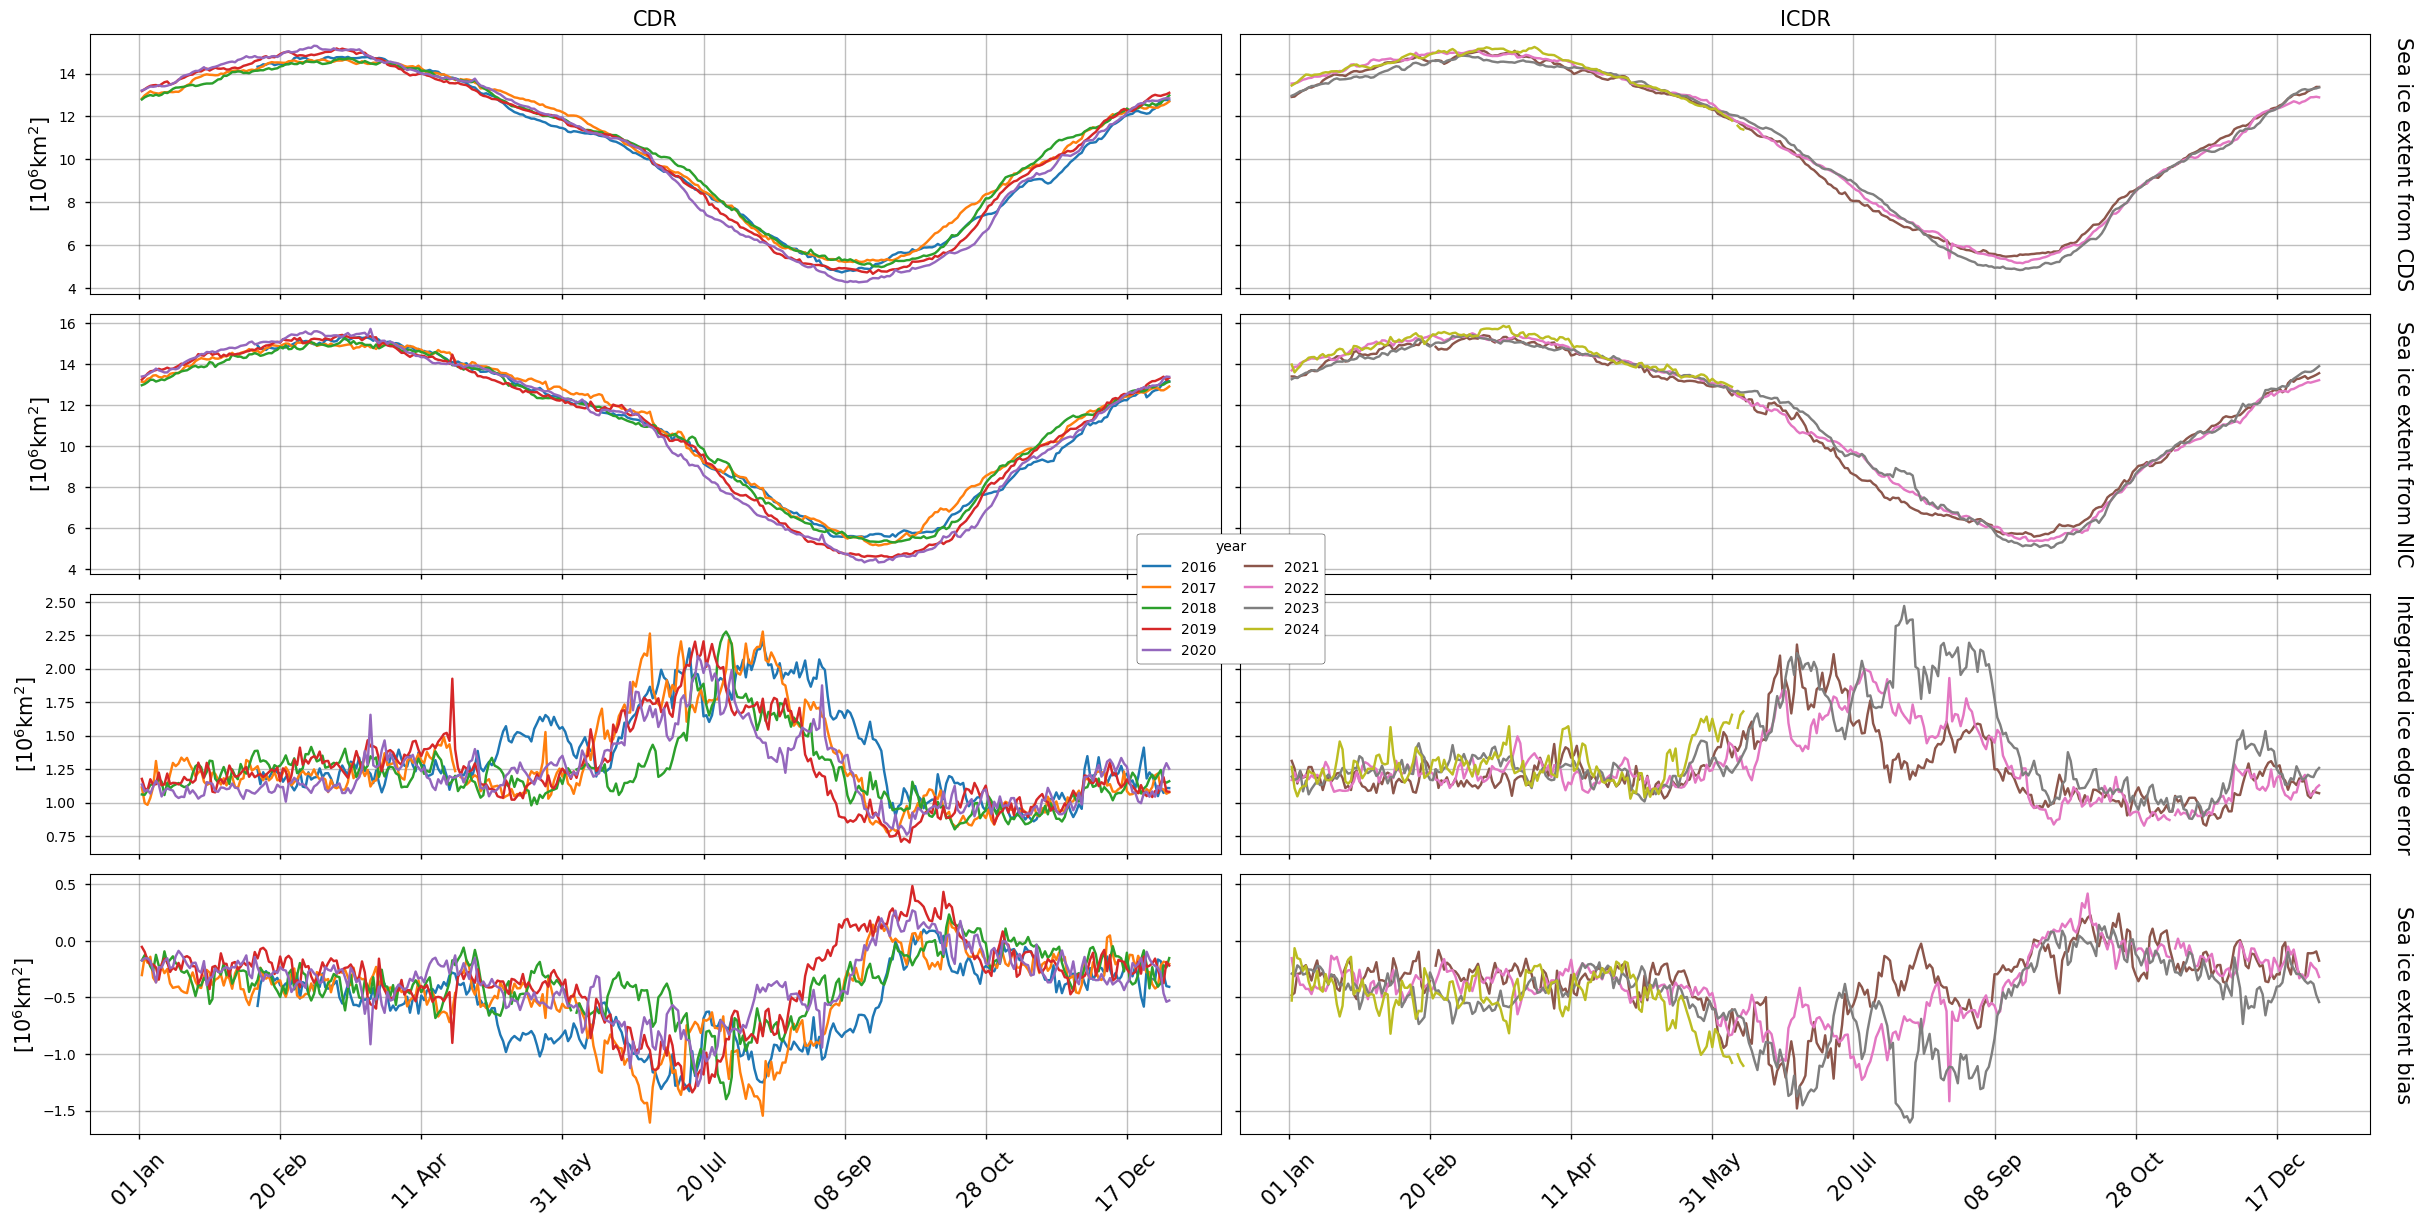

In [12]:
plot_time_series_doy(dataset_compare_nic.sel(region="northern_hemisphere"))

The maps below show monthly climatologies for the bias (CDS - NIC) in the probability of being ice-covered in the Arctic. The regions where there is disagreement - mostly ice in the ice charts, but not in the CDS - at the ice edge, which varies in location according to the time of year. In the winter months this is in the Labrador, Greenland and Barents Sea on the Atlantic side, and the Bering and Okhotsk Seas on the Pacific side. In the summer months there are also areas of disagreement off the Arctic and Siberian coasts and in the Hudson Bay. These areas are larger, possibly due to errors in the SIC from passive microwave sensors, and maybe also due to the ice edge being in more dynamic areas such as the Beaufort Sea.

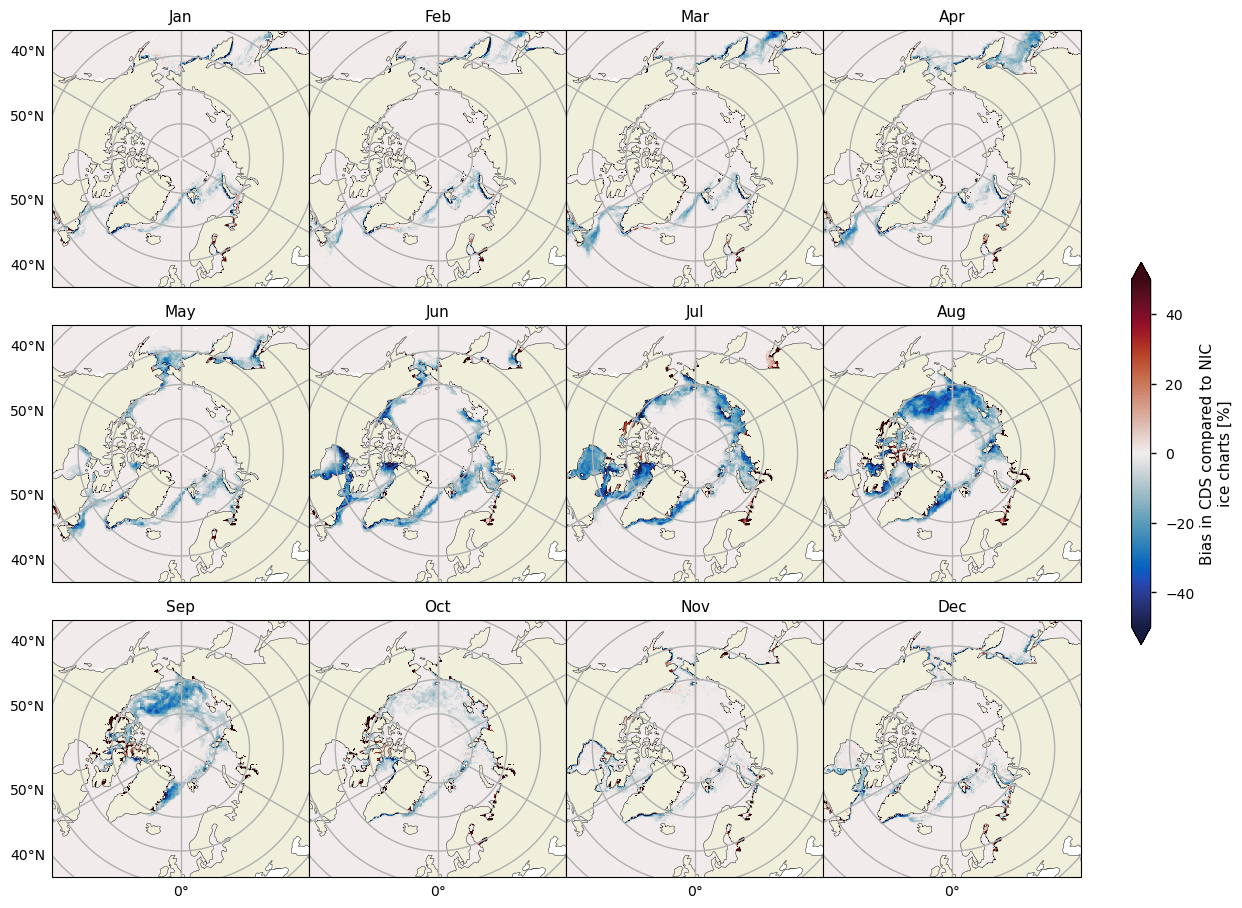

In [13]:
plot_bias_maps(datasets_maps, "northern_hemisphere")

#### 4.2 Southern hemisphere
Below we plot comparisons between the Antarctic sea ice extents in the CDS concentration datasets and the NIC ice charts. As with the Arctic time series, the upper two plots show they have fairly similar intra- and inter-annual variability, and there is again more variability at shorter time scales in the NIC extent. However, this variability has a higher amplitude than for the Arctic. The bias plot shows that CDS nearly always has less ice than NIC. The bias is largest in the summer months when the concentration from passive microwave sensors would be expected to have the greatest errors, at times exceeding $3 \times 10^6$km$^2$. The IIEE is only slightly higher, reflecting the fact that there are few areas where CDS has ice when NIC does not. It ranges between 1 and 2 $\times10^6$km$^2$ in winter, and between 2 and 4 $\times10^6$km$^2$ in summer. The years with the greatest IIEE are 2016. 2023 and 2024.

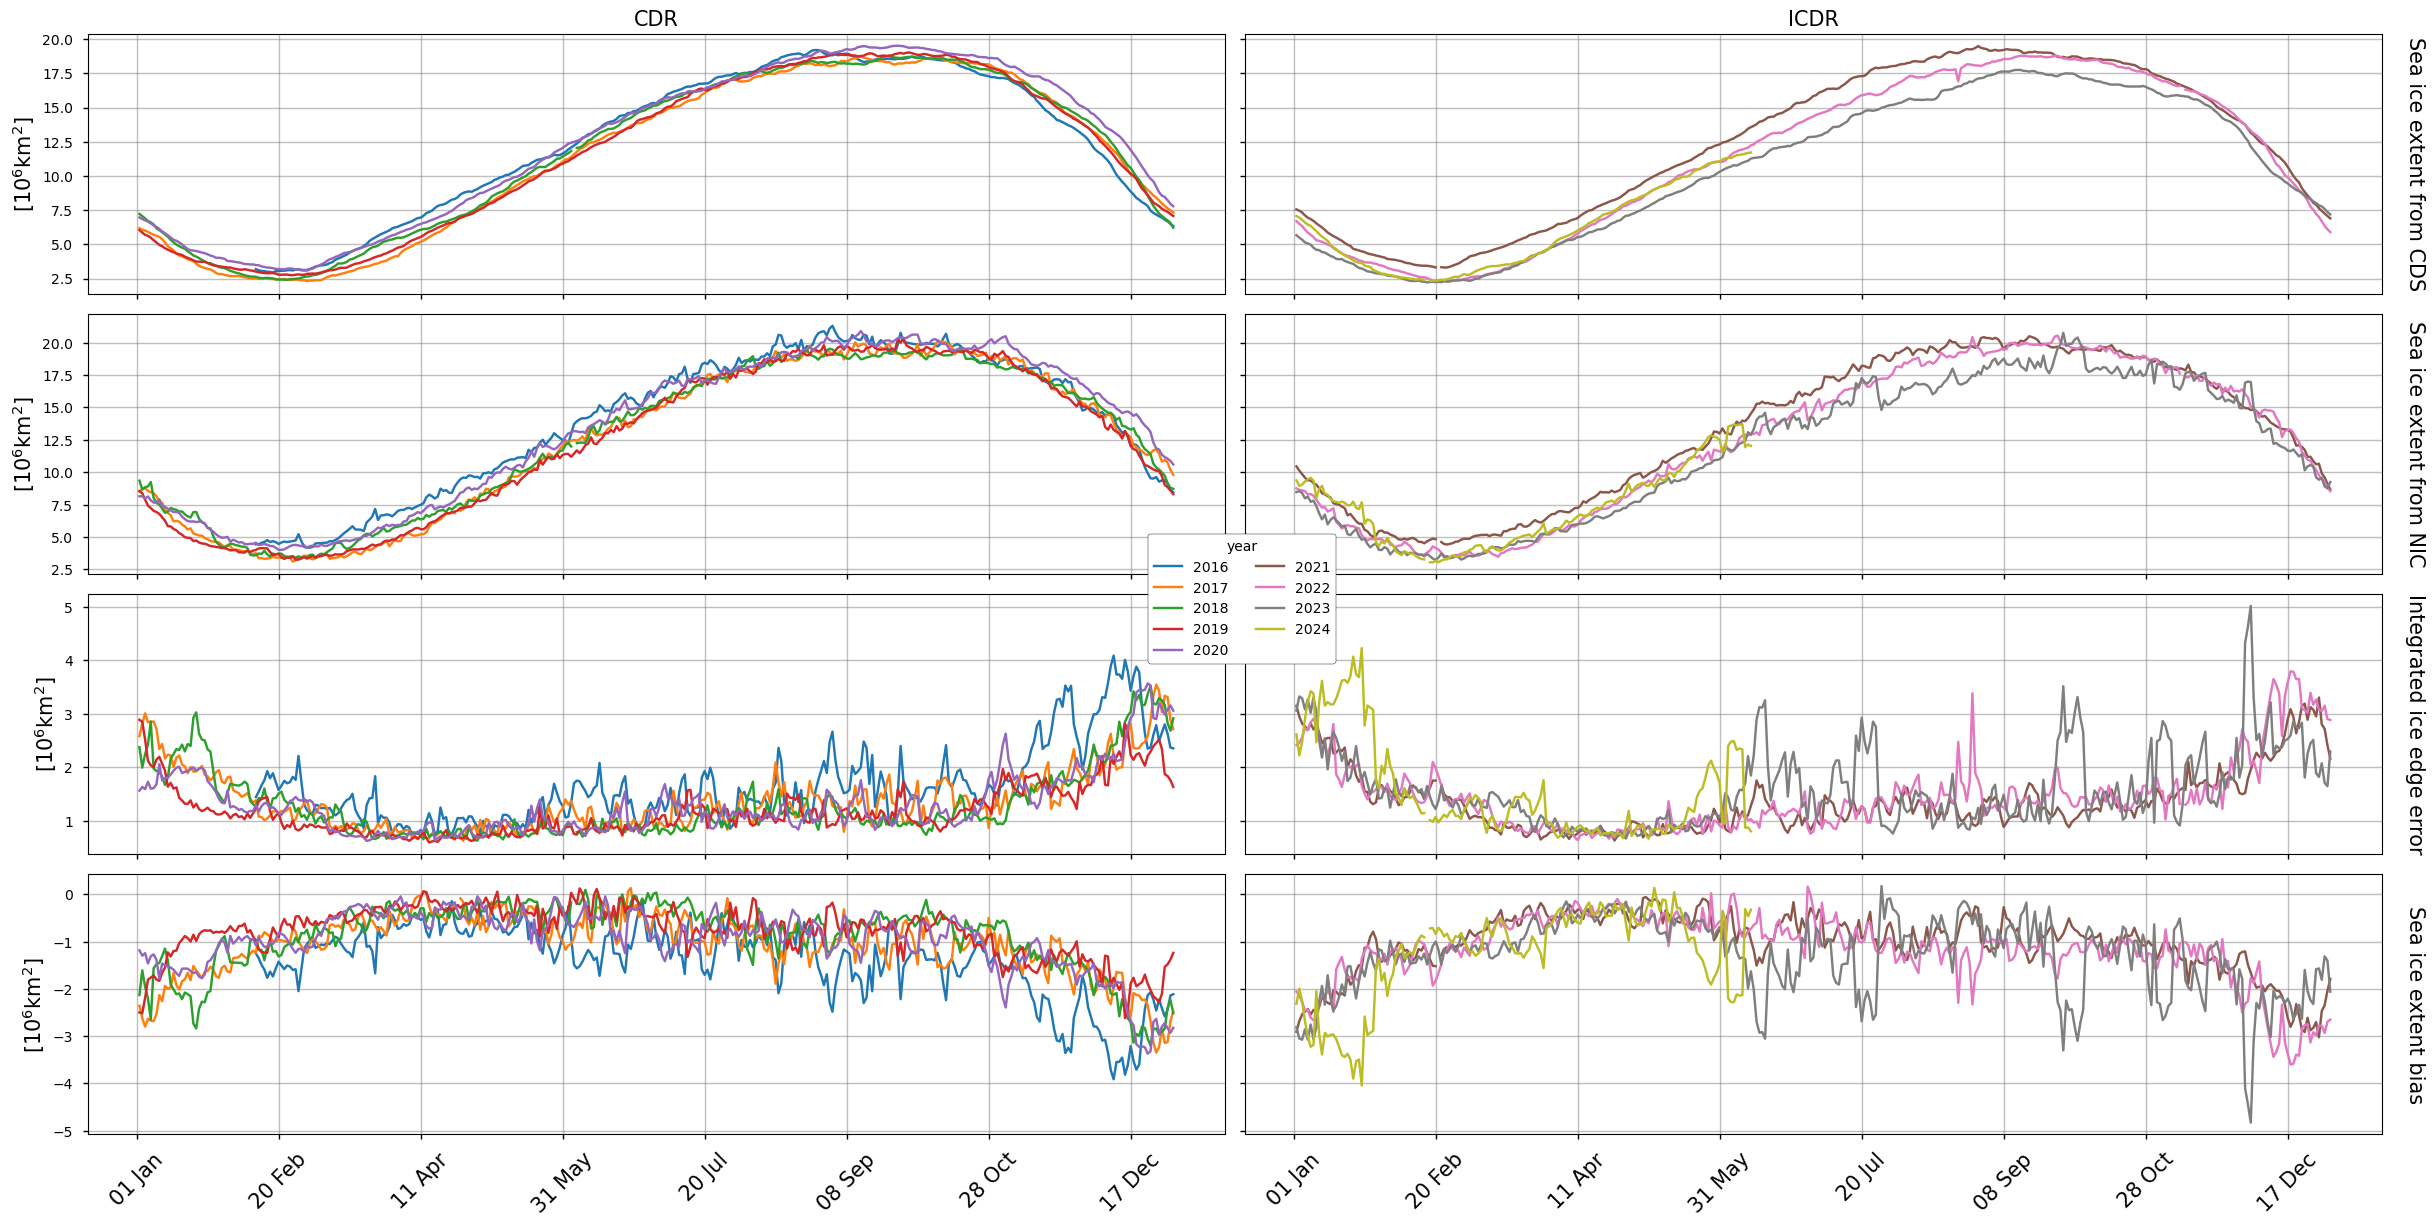

In [14]:
plot_time_series_doy(dataset_compare_nic.sel(region="southern_hemisphere"))

The maps below show monthly climatologies for the bias (CDS - NIC) in the probability of being ice-covered around Antarctica. In the winter months, the areas where the CDS and the NIC ice charts disagree are fairly uniformly spread around the continent. In the summer months, there are very large areas of disagreement in the Weddell, Bellingshausen and Ross Seas. In the Indian Ocean sector the areas of disagreement are biggest in summer but they are much less than in the Pacific and Atlantic sectors.

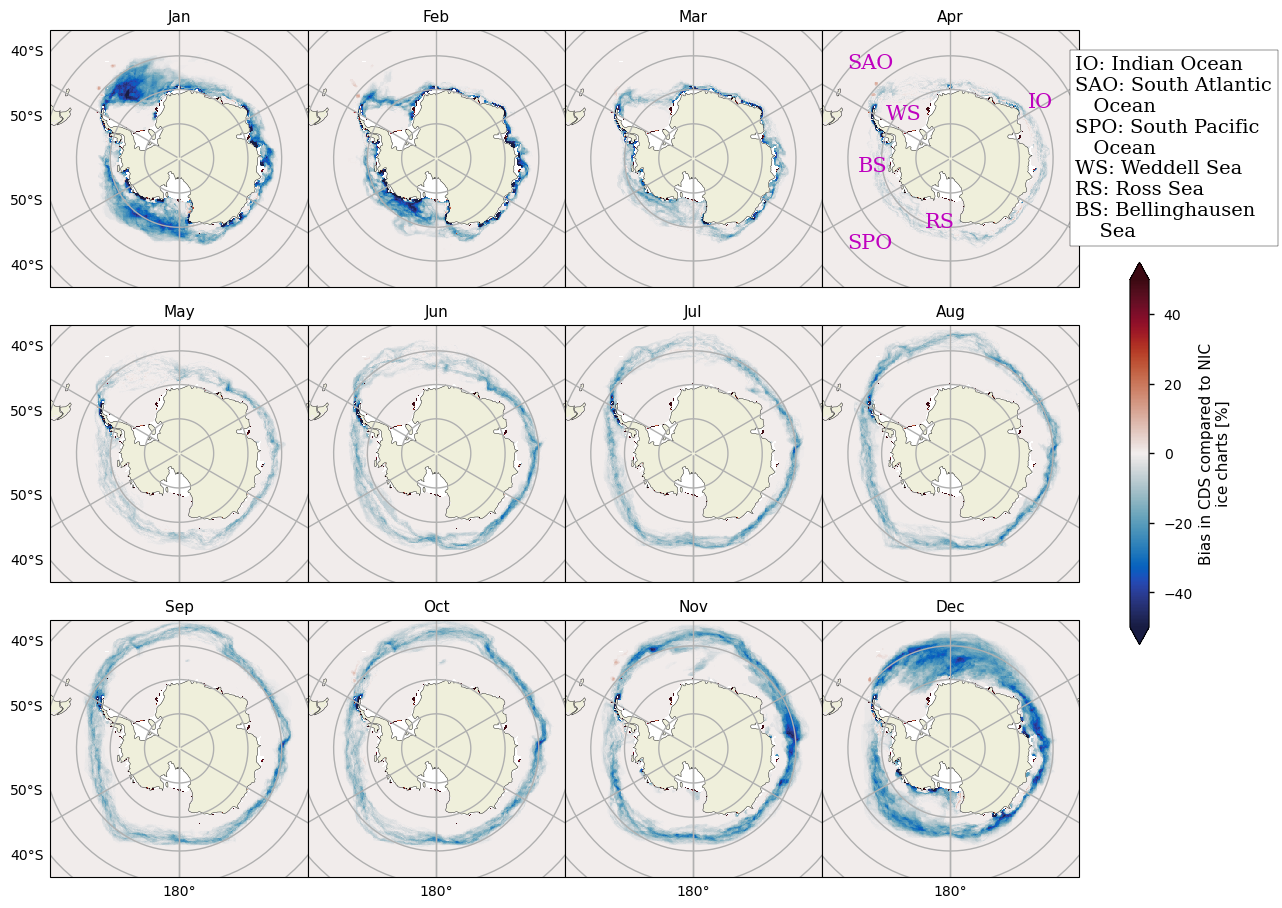

In [15]:
plot_bias_maps(datasets_maps, "southern_hemisphere")

## ℹ️ If you want to know more

### Key resources

Introductory sea ice materials:
- [<span style="color:blue">Role of sea ice in the climate</span>](https://www.epa.gov/climate-indicators/climate-change-indicators-arctic-sea-ice)
- [<span style="color:blue">Observing sea ice with satellites</span>](https://www.metoffice.gov.uk/research/climate/cryosphere-oceans/sea-ice/measure)

Code libraries used:
* [<span style="color:blue">C3S EQC custom functions</span>](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [<span style="color:blue">BOpen</span>](https://www.bopen.eu/)

Information on ice charts:
- [<span style="color:blue">NIC ice charts</span>](https://usicecenter.gov/Products)


### References

1. Ivanova, N., Pedersen, L. T., Tonboe, R. T., Kern, S., Heygster, G., Lavergne, T., Sørensen, A., Saldo, R., Dybkjær, G., Brucker, L., & Shokr, M. (2015). Inter-comparison and evaluation of sea ice algorithms: towards further identification of challenges and optimal approach using passive microwave observations. The Cryosphere, 9(5), 1797-1817, [<span style="color:blue">https://tc.copernicus.org/articles/9/1797/2015</span>](https://tc.copernicus.org/articles/9/1797/2015).


2. Comiso, J. C., Cavalieri, D. J., Parkinson, C. L., & Gloersen, P. (1997). Passive microwave algorithms for sea ice concentration: A comparison of two techniques. Remote sensing of Environment, 60(3), 357-384, [<span style="color:blue">https://doi.org/10.1016/S0034-4257(96)00220-9</span>](https://doi.org/10.1016/S0034-4257(96)00220-9).

3. Buckley, E. M., Horvat, C., & Yoosiri, P. (2024). Sea Ice Concentration Estimates from ICESat-2 Linear Ice Fraction. Part 1: Multi-sensor Comparison of Sea Ice Concentration Products. EGUsphere, 2024, 1-19, [<span style="color:blue">https://doi.org/10.5194/egusphere-2024-3861</span>](https://doi.org/10.5194/egusphere-2024-3861).

4. Goessling, H. F., Tietsche, S., Day, J. J., Hawkins, E., & Jung, T. (2016). Predictability of the Arctic sea ice edge. Geophysical Research Letters, 43(4), 1642-1650, [<span style="color:blue">https://doi.org/10.1002/2015GL067232</span>](https://doi.org/10.1002/2015GL067232).